# Imports

In [ ]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import transformers
import pandas as pd
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from dotenv import load_dotenv
load_dotenv()

True

Environment variables

In [ ]:
PATH = os.getenv("PATH")
DATAPATH = os.getenv("DATAPATH")
PREPARED_DATA_DIR = os.getenv("PREPARED_DATA_DIR")
CACHE_DIR = os.getenv("CACHE_DIR")
#TOK_NAME = "deepseek-ai/DeepSeek-R1-0528-Qwen3-8B"
TOK_NAME = os.getenv("TOK_NAME")
PARQUET_DATA_DIR = os.getenv("PARQUET_DATA_DIR")

## Config

In [3]:
GPT_CONFIG = {
    'vocab_size': 50257, # in 151670 (if you use tokenizer.vocab_size then you get partial vocab_size without added tokens)
    'context_length': 1024,
    'emb_dim': 768, #768
    'n_heads': 2,#12,
    'n_layers': 2,#12,
    'drop_rate': 0.05, # 0l1
    'qkv_bias': False
    }

In [4]:
device = 'cuda' if (torch.cuda.is_available()) else 'cpu'
device

'cuda'

# Dataset

## Load Tokenizer

In [5]:
tok = transformers.AutoTokenizer.from_pretrained(TOK_NAME, cache_dir=CACHE_DIR)

Check tokenizer

In [4]:
tok.get_added_vocab

<bound method PreTrainedTokenizerFast.get_added_vocab of LlamaTokenizerFast(name_or_path='deepseek-ai/DeepSeek-R1-0528-Qwen3-8B', vocab_size=151643, model_max_length=131072, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<｜begin▁of▁sentence｜>', 'eos_token': '<｜end▁of▁sentence｜>', 'pad_token': '<｜end▁of▁sentence｜>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	151643: AddedToken("<｜begin▁of▁sentence｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151644: AddedToken("<|im_start|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151645: AddedToken("<｜end▁of▁sentence｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151646: AddedToken("<|object_ref_start|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151647: AddedToken("<|object_ref_end|>", rstrip=False, lstrip=False, single_word=False, nor

In [7]:
tok.vocab_size

50257

In [6]:
# If tokenizer dont have pad_token
tok.pad_token = tok.eos_token

In [7]:
tok('Привет, как дела mhjm', return_tensors='pt', padding='max_length', max_length=2048)['input_ids'].shape

torch.Size([1, 2048])

# Prepare data

## Raw data

In [22]:
with open(DATAPATH, encoding='utf8', mode='r') as file:
    d = file.read()

In [26]:
len(d)

1423181938

In [38]:
1423181938//131072

10858

In [ ]:
num_chunks=25
stride = len(d)//num_chunks

for i, chunk_idx in tqdm(enumerate(range(0, len(d), stride))):
    with open(os.path.join(PREPARED_DATA_DIR, f'chunk_{i}.txt'), mode='w') as file:
        file.write(d[chunk_idx:chunk_idx+stride])
    print(i, chunk_idx)

0it [00:00, ?it/s]

0 0
1 56927277
2 113854554
3 170781831
4 227709108
5 284636385
6 341563662
7 398490939
8 455418216
9 512345493
10 569272770
11 626200047
12 683127324
13 740054601
14 796981878
15 853909155
16 910836432
17 967763709
18 1024690986
19 1081618263
20 1138545540
21 1195472817
22 1252400094
23 1309327371
24 1366254648
25 1423181925


In [ ]:
#num_chunks=25
stride = 131072#len(d)//num_chunks

data_parquet = pd.DataFrame([], columns=['Sample', 'Chunk'])
for i, chunk_idx in tqdm(enumerate(range(0, len(d), stride))):
    data_parquet.loc[len(data_parquet)] = ['sdgsgsg', 0]
    #with open(os.path.join(PREPARED_DATA_DIR, f'chunk_{i}.txt'), mode='w') as file:
    #    file.write(d[chunk_idx:chunk_idx+stride])
    print(i, chunk_idx)

In [27]:
data_parquet = pd.DataFrame([], columns=['Sample', 'Chunk'])
for i, filename in tqdm(enumerate(os.listdir(PREPARED_DATA_DIR)), total=len(os.listdir(PREPARED_DATA_DIR))):
    with open(os.path.join(PREPARED_DATA_DIR, filename), encoding='utf8', mode='r') as file:
        current_file = file.read()
        stride = 2048*3
        mas = ''
        for article in current_file.split('/n'):
            for sentence in article.split('.'):
                if (len(mas)+len(sentence) < stride):
                    mas += sentence
                else:
                    data_parquet.loc[len(data_parquet)] = [mas, i]
                    mas = ''
            
        # for chunk_idx in tqdm(range(0, len(current_file), stride)):
        #     current_chunk = current_file[chunk_idx:chunk_idx+stride]
        #     data_parquet.loc[len(data_parquet)] = ['sdgsgsg', 0]

  0%|          | 0/26 [00:00<?, ?it/s]

In [29]:
2048*3

6144

In [ ]:
data_parquet.to_parquet(PARQUET_DATA_DIR)

In [6]:
d[200:250]

'ение составляет  человек (август, 2023). Занимает '

## Analysis

Небольшой анализ длины предложений

In [4]:
with open(os.path.join(PREPARED_DATA_DIR, os.listdir(PREPARED_DATA_DIR)[0]), encoding='utf8', mode='r') as file:
    d = file.read()

In [13]:
splt = d.split('.')

In [14]:
lens = [len(elem) for elem in splt]

In [15]:
max(lens)

13172

(array([2.10951e+05, 1.75914e+05, 1.06745e+05, 5.57980e+04, 2.66940e+04,
        1.28720e+04, 6.20800e+03, 3.26600e+03, 1.80200e+03, 1.11300e+03,
        7.79000e+02, 5.09000e+02, 3.46000e+02, 2.56000e+02, 2.12000e+02,
        1.57000e+02, 1.24000e+02, 8.60000e+01, 9.60000e+01, 6.60000e+01]),
 array([   0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.,  400.,
         450.,  500.,  550.,  600.,  650.,  700.,  750.,  800.,  850.,
         900.,  950., 1000.]),
 <BarContainer object of 20 artists>)

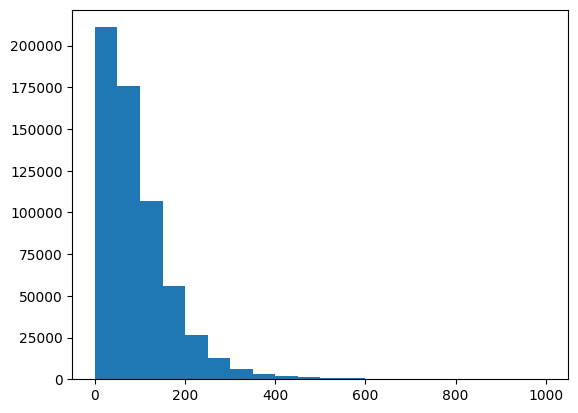

In [20]:
plt.hist(lens, bins=20, range=(0, 1000))

Если взять длину абзацев

In [19]:
splt = d.split('/n')

In [25]:
splt[10]

'auch_trudi/osnovy-golosovedenija-2009.pdf\n Насретдинов А. Физика и анатомия музыки. 2015\xa0г. М.: Бослен, 224 с\n\nСсылки \n\n Пекерская Е. М. [lib.ru/CULTURE/MUSICACAD/PECERSKAYA/vocal.txt Вокальный букварь].\n Почему исчезает голос.\n\nДыхательная система\nРечевая коммуникация\nПение\nЛогопедия\nФониатрия\nУ́ксусный ангидри́д (ангидри́д у́ксусной кислоты́), (CH3CO)2O, Ac2O — бесцветная жидкость с резким запахом, растворимая в бензоле, диэтиловом эфире и других органических растворителях. Находит весьма широкое применение в промышленности и органическом синтезе.\n\nПромышленные методы получения\n\nУстаревшие методы \nИсторически первый метод синтеза уксусного ангидрида был основан на превращении ацетата натрия CH3COONa в ацетилхлорид CH3COCl под действием неорганического хлорида (обычно хлористого тионила SOCl2, хлористого сульфурила SO2Cl2 или хлористого фосфорила POCl3). На второй стадии образовавшийся ацетилхлорид реагировал с избытком ацетата натрия с образованием уксусного анг

In [24]:
len(splt)

26

In [21]:
lens = [len(elem) for elem in splt]

In [22]:
max(lens)

10362976

(array([10.,  2.,  4.,  1.,  2.,  2.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  1.,  0.,  1.,  0.,  1.]),
 array([1.2000000e+01, 5.1816020e+05, 1.0363084e+06, 1.5544566e+06,
        2.0726048e+06, 2.5907530e+06, 3.1089012e+06, 3.6270494e+06,
        4.1451976e+06, 4.6633458e+06, 5.1814940e+06, 5.6996422e+06,
        6.2177904e+06, 6.7359386e+06, 7.2540868e+06, 7.7722350e+06,
        8.2903832e+06, 8.8085314e+06, 9.3266796e+06, 9.8448278e+06,
        1.0362976e+07]),
 <BarContainer object of 20 artists>)

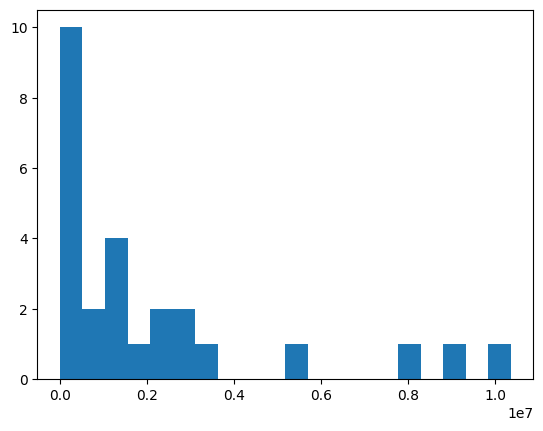

In [23]:
plt.hist(lens, bins=20)

Class for dataset

## Old versions of dataset

In [ ]:
class CustomDatasetV1(Dataset):
    def __init__(self, txt: str, tokenizer: object, max_length: int, stride: int):
        self.tokenizer = tokenizer
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt)

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1:i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
        
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, index):
        return self.input_ids[index], self.target_ids[index]

In [13]:
class CustomDatasetV2(Dataset):
    def __init__(self, dataframe: str, tokenizer: object, max_length: int, stride: int):
        self.tokenizer = tokenizer
        self.input_ids = []
        self.target_ids = []

        for i, curr_chunk in dataframe.iterrows():
            token_ids = tokenizer.encode(curr_chunk['Sample'])
            for i in range(0, len(token_ids) - max_length, stride):
                input_chunk = token_ids[i:i + max_length]
                target_chunk = token_ids[i + 1:i + max_length + 1]
                self.input_ids.append(torch.tensor(input_chunk))
                self.target_ids.append(torch.tensor(target_chunk))
        
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, index):

        return self.input_ids[index], self.target_ids[index]

In [ ]:
cd = CustomDatasetV2(dataframe=data_parquet.iloc[:100], tokenizer=tok, max_length=1024, stride=1)

## Actual version of dataset

In [7]:
class CustomDatasetV3(Dataset):
    def __init__(self, dataframe: str, tokenizer: object, max_length: int):
        self.tokenizer = tokenizer
        self.input_ids = []
        self.target_ids = []

        for i, curr_chunk in tqdm(dataframe.iterrows(), total=dataframe.shape[0]):
            token_ids = tokenizer(curr_chunk['Sample'], return_tensors='pt', padding='max_length', max_length=max_length+1)['input_ids']
            input_chunk = token_ids[:,:max_length].view(-1)
            target_chunk = token_ids[:,1:max_length+1].view(-1)
            #print(input_chunk.size(), target_chunk.size(),)
            self.input_ids.append(input_chunk)
            self.target_ids.append(target_chunk)
        
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, index):

        return self.input_ids[index], self.target_ids[index]

# Load actual data and dataloader

In [20]:
data_parquet = pd.read_parquet(PARQUET_DATA_DIR)

In [9]:
data_parquet.shape

(224662, 2)

In [ ]:
train_cd = CustomDatasetV3(dataframe=data_parquet.iloc[:100000], tokenizer=tok, max_length=GPT_CONFIG['context_length'])#MY_GPT_CONFIG['context_length'])
#train_cd = CustomDatasetV3(dataframe=data_parquet.iloc[:100], tokenizer=tok, max_length=GPT_CONFIG['context_length'])#MY_GPT_CONFIG['context_length'])

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
val_cd = CustomDatasetV3(dataframe=data_parquet.iloc[-10000:], tokenizer=tok, max_length=GPT_CONFIG['context_length'])#MY_GPT_CONFIG['context_length'])
#val_cd = CustomDatasetV3(dataframe=data_parquet.iloc[-100:], tokenizer=tok, max_length=GPT_CONFIG['context_length'])#

  0%|          | 0/10 [00:00<?, ?it/s]

In [23]:
train_data = DataLoader(dataset=train_cd, batch_size=4, shuffle=True, num_workers=0)
val_data = DataLoader(dataset=val_cd, batch_size=4, shuffle=True, num_workers=0)

In [27]:
next(iter(train_data))

[tensor([[  198,   198,   140,  ..., 15166, 21169, 18849],
         [12466,    94, 25443,  ...,  4764, 12466,   116],
         [ 1849,   141,   230,  ..., 21169, 25443,   123],
         [  198,   140,   254,  ...,   228, 18849, 22177]]),
 tensor([[  198,   140,   240,  ..., 21169, 18849, 18849],
         [   94, 25443,   111,  ..., 12466,   116,   140],
         [  141,   230,   198,  ..., 25443,   123, 16843],
         [  140,   254, 12466,  ..., 18849, 22177, 16142]])]

# LLM Code

## Simple Attention

### With prints

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0)
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length)))

    def forward(self, x):
        b, num_tokens, d_in = x.size()
        keys = self.W_key(x) # b, num_tokens, self.d_out
        queries = self.W_query(x) # b, num_tokens, self.d_out
        values = self.W_value(x) # b, num_tokens, self.d_out
        print('values.shape is ' , values.shape)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        print('values.shape (after view) is ' , values.shape)

        keys = keys.transpose(1, 2) # b, self.num_heads, num_tokens, self.head_dim
        queries = queries.transpose(1, 2) # b, self.num_heads, num_tokens, self.head_dim
        values = values.transpose(1, 2) # b, self.num_heads, num_tokens, self.head_dim
        print('values.shape (after transpose) is ' , values.shape)

        att_scores = queries @ keys.transpose(2, 3) # shapes = (num_tokens, self.head_dim) @ (self.head_dim, num_tokens) -> (num_tokens, num_tokens)
        print('att_scores.shape is ' , att_scores.shape)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        att_scores.masked_fill_(mask_bool, -torch.inf)

        att_weights = torch.softmax(att_scores / keys.shape[-1]**.5, dim=-1)
        att_weights = self.dropout(att_weights)

        context_vec = (att_weights @ values).transpose(1, 2) # (num_tokens, num_tokens) @ (num_tokens, self.head_dim) -> (num_tokens, self.head_dim) -> transpose(1,2) of (b, self.num_heads, num_tokens, self.head_dim) ->
        # -> (b, num_tokens, self.num_heads, self.head_dim) as view in previous code after inference of Linear layers
        print('context_vec.shape is ' , att_scores.shape)
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        print('context_vec.shape is ' , att_scores.shape)
        context_vec = self.out_proj(context_vec)
        return context_vec

#### Check

In [ ]:
mha = MultiHeadAttention(d_in=768, d_out=768, context_length=2048, dropout=0.1, num_heads=4)

In [ ]:
torch.rand(10, 2048, 768).size()

torch.Size([10, 2048, 768])

In [ ]:
a = mha(torch.rand(10, 2048, 768))

In [ ]:
a.shape

torch.Size([10, 2048, 768])

### Without prints

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0)

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.size()
        keys = self.W_key(x) # b, num_tokens, self.d_out
        queries = self.W_query(x) # b, num_tokens, self.d_out
        values = self.W_value(x) # b, num_tokens, self.d_out

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1, 2) # b, self.num_heads, num_tokens, self.head_dim
        queries = queries.transpose(1, 2) # b, self.num_heads, num_tokens, self.head_dim
        values = values.transpose(1, 2) # b, self.num_heads, num_tokens, self.head_dim

        att_scores = queries @ keys.transpose(2, 3) # shapes = (num_tokens, self.head_dim) @ (self.head_dim, num_tokens) -> (num_tokens, num_tokens)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        att_scores.masked_fill_(mask_bool, -torch.inf)

        att_weights = torch.softmax(att_scores / keys.shape[-1]**0.5, dim=-1)
        att_weights = self.dropout(att_weights)

        context_vec = (att_weights @ values).transpose(1, 2) # (num_tokens, num_tokens) @ (num_tokens, self.head_dim) -> (num_tokens, self.head_dim) -> transpose(1,2) of (b, self.num_heads, num_tokens, self.head_dim) ->
        # -> (b, num_tokens, self.num_heads, self.head_dim) as view in previous code after inference of Linear layers
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)
        return context_vec

## Other Attention

In [11]:
class CausalSelfAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, num_heads,):
        super().__init__()
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(d_in, 3 * d_in)
        # output projection
        self.c_proj = nn.Linear(d_in, d_in)
        # regularization
        self.n_head = num_heads
        self.n_embd = d_out

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True) # flash attention
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y

## Additional classes

In [9]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [15]:
# class LayerNorm(nn.Module):
#     def __init__(self, emb_dim):
#         super().__init__()
#         self.eps = 1e-5
#         self.scale = nn.Parameter(torch.ones(emb_dim))
#         self.shift = nn.Parameter(torch.zeros(emb_dim))

#     def forward(self, x):
#         mean = x.mean(dim=-1, keepdim=True)
#         var = x.var(dim=-1, keepdim=True, unbiased=False)
#         norm_x = (x - mean) / torch.sqrt(var + self.eps)
#         return self.scale * norm_x + self.shift

In [16]:
# class GELU(nn.Module):
#     def __init__(self):
#         super().__init__()

#     def forward(self, x):
#         return 0.5 * x * (1 + torch.tanh( torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3)) ))

In [10]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [11]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg['emb_dim'], 4 * cfg['emb_dim']),
            GELU(),
            nn.Linear(4 * cfg['emb_dim'], cfg['emb_dim'])
        )
    def forward(self, x):
        return self.layers(x)

## Transformer Block

In [12]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.attn = MultiHeadAttention(d_in=cfg['emb_dim'], 
                                       d_out=cfg['emb_dim'], 
                                       context_length=cfg['context_length'], 
                                       dropout=cfg['drop_rate'], 
                                       num_heads=cfg['n_heads'], 
                                       qkv_bias=cfg['qkv_bias'])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.drop_resid = nn.Dropout(cfg['drop_rate'])
    
    def forward(self, x):
        #x = x + self.drop_resid(self.attn(self.norm1(x)))
        #x = x + self.drop_resid(self.ff(self.norm2(x)))
        shortcut = x
        x = self.norm1(x)
        x = self.attn(x)
        x = self.drop_resid(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_resid(x)
        x = x + shortcut
        return x

In [20]:
# class TransformerBlock(nn.Module):
#     def __init__(self, cfg):
#         super().__init__()
#         self.att = MultiHeadAttention(
#             d_in=cfg["emb_dim"],
#             d_out=cfg["emb_dim"],
#             context_length=cfg["context_length"],
#             num_heads=cfg["n_heads"], 
#             dropout=cfg["drop_rate"],
#             qkv_bias=cfg["qkv_bias"])
#         self.ff = FeedForward(cfg)
#         self.norm1 = LayerNorm(cfg["emb_dim"])
#         self.norm2 = LayerNorm(cfg["emb_dim"])
#         self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

#     def forward(self, x):
#         # Shortcut connection for attention block
#         shortcut = x
#         x = self.norm1(x)
#         x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
#         x = self.drop_shortcut(x)
#         x = x + shortcut  # Add the original input back

#         # Shortcut connection for feed forward block
#         shortcut = x
#         x = self.norm2(x)
#         x = self.ff(x)
#         x = self.drop_shortcut(x)
#         x = x + shortcut  # Add the original input back

#         return x

### Check

In [35]:
tb = TransformerBlock(GPT_CONFIG)

In [21]:
GPT_CONFIG

{'vocab_size': 50257,
 'context_length': 1024,
 'emb_dim': 768,
 'n_heads': 2,
 'n_layers': 2,
 'drop_rate': 0.1,
 'qkv_bias': False}

In [12]:
init_size = 10, 1024, 768

In [34]:
tb(torch.rand(*init_size, device='cpu')).size()

torch.Size([10, 1024, 768])

In [36]:
tb(torch.rand(*init_size, device='cpu'))

tensor([[[    nan,     nan,     nan,  ...,     nan,     nan,     nan],
         [-0.1282,  0.1958,  0.4158,  ...,  0.1775,  0.8038,  0.7860],
         [ 0.7502, -0.4513,  0.6417,  ..., -0.0071,  0.3187,  0.3782],
         ...,
         [ 0.9968,  0.1533, -0.2926,  ..., -0.0057,  0.3411,  0.7333],
         [ 0.1944, -0.0979,  0.7427,  ...,  0.4760,  0.3513,  0.3321],
         [ 0.4361,  0.0266, -0.0217,  ...,  0.4803, -0.2651,  0.7020]],

        [[    nan,     nan,     nan,  ...,     nan,     nan,     nan],
         [ 0.3157,  0.6540, -0.2170,  ...,  0.2235,  0.1626,  0.8510],
         [ 0.8748,  0.3798, -0.1871,  ...,  0.3344,  0.0285,  1.1137],
         ...,
         [ 0.8981,  0.1823,  0.8073,  ...,  0.4379,  0.6960,  0.2674],
         [ 0.2251,  0.2450,  0.9060,  ...,  0.3705,  0.9815,  0.7649],
         [ 0.6568,  0.5581,  0.9443,  ..., -0.0993,  0.3415,  0.5553]],

        [[    nan,     nan,     nan,  ...,     nan,     nan,     nan],
         [-0.6134,  0.7787, -0.1709,  ...,  0

In [13]:
s = nn.Sequential(*[TransformerBlock(GPT_CONFIG) for _ in range(4)])

In [14]:
s(torch.rand(*init_size))

tensor([[[ 1.1181e+00,  9.0072e-02, -9.7242e-02,  ..., -7.9379e-01,
           9.1935e-01,  1.6051e+00],
         [ 4.5545e-01,  1.4940e+00, -6.5898e-01,  ..., -1.4196e+00,
          -1.1886e-01,  5.9312e-01],
         [ 6.9797e-01, -1.1730e+00, -1.4681e-01,  ..., -6.9243e-01,
          -3.3176e-01,  2.8703e-01],
         ...,
         [ 1.0198e+00,  6.5788e-01, -3.9724e-02,  ...,  6.1315e-01,
          -1.5974e-01,  1.2915e+00],
         [ 5.9596e-01,  6.0242e-01,  5.7316e-01,  ..., -2.0221e-01,
           1.2505e-01,  5.1213e-01],
         [ 3.1996e-02,  3.2923e-01, -2.1279e-02,  ...,  2.8866e-01,
           4.9295e-01,  1.0546e+00]],

        [[ 6.7451e-01, -6.1569e-01,  1.3098e+00,  ...,  1.2463e+00,
           8.5620e-01, -3.8584e-01],
         [ 1.5214e-01, -1.3334e+00,  9.2979e-01,  ..., -9.8272e-01,
          -5.7479e-02, -4.0280e-01],
         [ 4.4263e-02, -8.4143e-01,  2.4693e-01,  ...,  3.2636e-01,
           5.3633e-01, -6.6726e-01],
         ...,
         [ 1.0273e-01,  1

In [14]:
s(torch.rand(*init_size)).size()

torch.Size([10, 1024, 768])

In [15]:
init_size == s(torch.rand(*init_size)).size()

True

In [180]:
init_size == tb(torch.rand(init_size)).size()

True

## GPT class

In [13]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])

        self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg['n_layers'])])
        self.final_norm = nn.LayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.size()
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

### Check

In [53]:
m = GPTModel(GPT_CONFIG)

In [54]:
for x, y in data_load:
    print(x.size())
    r = m(x)
    break

torch.Size([10, 1024])


In [55]:
r.size()

torch.Size([10, 1024, 50257])

## Generation

In [14]:
def generate(model, idx, max_new_tokens, context_size):
    model.eval()
    for _ in range(max_new_tokens):
        idx_cond = idx[:,-context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

### Check

In [64]:
torch.tensor(tok('Привет, как дела ')['input_ids']).unsqueeze(0), #tok('Привет, как дела mhjm', return_tensors='pt', padding='max_length', max_length=2048)['input_ids'].shape
# tok('Привет, как дела mhjm', return_tensors='pt', padding='max_length', max_length=1024)['input_ids'].shape

(tensor([[  140,   253, 21169, 18849, 38857, 16843, 20375,    11, 12466,   118,
          16142, 31583, 12466,   112, 16843, 30143, 16142,   220]]),)

In [74]:
tok.decode(generate(model=m, idx=torch.tensor(tok('Привет, как дела ')['input_ids']).unsqueeze(0), max_new_tokens=20, context_size=1024).squeeze(0).tolist())

'Привет, как дела  eyes Lic hybrid Runs Skies07Attributeteenblogs scaleacia girltics detracteconomjump390 digital aided Remastered'

In [76]:
torch.tensor([1,2,3]).unsqueeze(0)

tensor([[1, 2, 3]])

In [78]:
torch.tensor([1,2,3]).unsqueeze(1)

tensor([[1],
        [2],
        [3]])

In [80]:
torch.tensor([[1,2,3]]).squeeze(0)

tensor([1, 2, 3])

## Training

In [27]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [28]:
class Trainer():
    def __init__(self, optimizer, params, device):
        self.optimizer = optimizer
        self.params = params
        self.device = device
    
    def train_model(self, model, tokenizer, train_dataloader, val_dataloader, writer=None):
        train_loss = []
        val_loss = []
        tokens_get = 0
        for epoch in range(self.params['N_EPOCHS']):

            
            for x, y in train_dataloader:
                if not (model.training):
                    model.train()
                x, y = x.to(self.device), y.to(self.device)
                self.optimizer.zero_grad()
                logits = model(x)
                loss = nn.functional.cross_entropy(logits.flatten(0, 1), y.flatten())
                loss.backward()
                self.optimizer.step()
                train_loss.append(loss)
                tokens_get += len(x.flatten())

                if (self.params['verbose'] is True) and (tokens_get % self.params['verbose_freq'] == 0):
                    sample = tokenizer.decode(generate(model=model, idx=torch.tensor(tokenizer('Я большая языковая модель и ')['input_ids'], device=self.device).unsqueeze(0), max_new_tokens=25, context_size=1024).squeeze(0).tolist())
                    print(f'Epoch {epoch}: Train loss = {loss}, sample: {sample}')
                    if (writer is not None):
                        writer.add_scalar("Loss/train in step", loss, epoch)
                        writer.add_text("Sample", str(sample), epoch)
                        if (self.params['gradients'] is True):
                            grads = []
                            for name, param in model.named_parameters():
                                if ('weight' in name):
                                    grads.append(param.grad.abs().flatten().mean().cpu().detach().numpy())
                            writer.add_scalar("train/gradients", np.array(grads).flatten().mean(), epoch)


                    model.eval()
                    with torch.no_grad():
                        for x, y in val_dataloader:
                            x, y = x.to(self.device), y.to(self.device)
                            logits = model(x)
                            loss = nn.functional.cross_entropy(logits.flatten(0, 1), y.flatten())
                            val_loss.append(loss)
                        if (writer is not None):
                            writer.add_scalar("Loss/train in check", torch.mean(torch.tensor(train_loss, device='cpu')), epoch)
                            writer.add_scalar("Loss/val in check", torch.mean(torch.tensor(val_loss, device='cpu')), epoch)
            writer.close()
            

In [29]:
params = {'N_EPOCHS': 5, 
          'verbose': True, 
          'verbose_freq': 1,
          'gradients': True}

In [30]:
model = GPTModel(GPT_CONFIG)

In [31]:
model = model.to(device)

In [32]:
opt = torch.optim.AdamW(params=model.parameters(), lr=0.01)
trainer = Trainer(optimizer=opt, params=params, device=device)

In [33]:
trainer.train_model(model=model, tokenizer=tok, train_dataloader=train_data, val_dataloader=val_data, writer=writer)
writer.flush()

Epoch 0: Train loss = 10.977889060974121, sample: Я большая языковая модель и е �е �е �е �е �е �е �е �е �е �е �е �е
Epoch 0: Train loss = 7.078422546386719, sample: Я большая языковая модель и  � � � � � � � � � � � � � � � � � � � � � � � � �
Epoch 0: Train loss = 4.9288249015808105, sample: Я большая языковая модель и ссссссссссссссссссссссссс
Epoch 0: Train loss = 5.983907699584961, sample: Я большая языковая модель и лл�лл�ллл�ллллл�лллл�л�лл
Epoch 0: Train loss = 6.905112266540527, sample: Я большая языковая модель и                          
Epoch 0: Train loss = 7.447443962097168, sample: Я большая языковая модель и о�о�о�о�о�о�о�о�о�о�о�о�о�о�о�о�о�о�о�о�о�о�о�о�о�
Epoch 0: Train loss = 6.8631367683410645, sample: Я большая языковая модель и еееееееееееееееееееееееее
Epoch 0: Train loss = 6.961722373962402, sample: Я большая языковая модель и ии�����������������������
Epoch 0: Train loss = 6.0047736167907715, sample: Я большая языковая модель и ааааааааааааааааааааааааа
Epoch 0

KeyboardInterrupt: 

How to use tensorboard?  
tensorboard --logdir=GPT_training or you name (instead of GPT_training) or tensorboard --logdir=runs  
http://localhost:6006  

### Saving weights

In [34]:
#torch.save(model.state_dict(), "model.pth") # without state of optimizer
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': opt.state_dict(),
    }, "model_and_optimizer.pth") # with state of optimizer

### Loading weights

In [15]:
checkpoint = torch.load("model_and_optimizer.pth")
model = GPTModel(GPT_CONFIG)
model.load_state_dict(checkpoint['model_state_dict'])
opt = torch.optim.AdamW(model.parameters(), lr=0.01)
opt.load_state_dict(checkpoint['optimizer_state_dict'])
model.train()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.05, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.05, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.05, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_key): Linear(in_feature

In [33]:
torch.randint(0, 100, size=(10, 1024)).size()

torch.Size([10, 1024])

In [36]:
model(torch.randint(0, 100, size=(50, 1024))).size()

: 